## Data Import


In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.metrics import Precision, Recall, AUC, Accuracy
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

In [2]:
df_train = pd.read_csv("dataset/output/no-oversampling/train.csv")
df_test = pd.read_csv("dataset/output/test.csv")

In [3]:
df_train.head()

,sex,pregnant,lithium,TSH,T3_measured,T4U,FTI,TBG_measured,target
0,0,0,0,1.70,1,0.98,99.0,0,1
1,0,1,0,0.05,1,1.75,165.0,0,1
2,1,0,0,0.25,1,0.75,166.0,0,1
3,1,0,0,1.00,1,0.95,101.0,0,1
4,0,0,0,0.10,0,0.82,145.0,0,0


## Data Preparation


In [3]:
# split into X_train, y_train, X_test, y_test
X_train = df_train.drop(columns=["target"])
y_train = df_train["target"]
X_test = df_test.drop(columns=["target"])
y_test = df_test["target"]

In [4]:
# normalize X_train, X_test, y_train, y_test
X_train = normalize(X_train)
X_test = normalize(X_test)
y_train = normalize(y_train.values.reshape(-1, 1))
y_test = normalize(y_test.values.reshape(-1, 1))

## Helper Functions


In [5]:
# This plots the auc against iteration to detect overfitting
def plot_hist(hist, metric="accuracy"):
    plt.plot(hist.history[metric])
    plt.plot(hist.history["val_" + metric])
    plt.title(f"model performance")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    return

## Model Building


### Base Model


In [7]:
# create a base LSTM model
def create_model():
    model = Sequential()
    model.add(
        LSTM(
            units=128,
            return_sequences=True,
            input_shape=(X_train.shape[1], 1),
        )
    )
    model.add(Dropout(0.2))
    model.add(LSTM(units=128))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy", Precision(), Recall()],
    )
    return model

In [12]:
# initialize model and fit to data
model = create_model()
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)],
)

Epoch 1/100
281/281 [==============================] - 18s 35ms/step - loss: 0.6636 - accuracy: 0.6253 - precision_2: 0.3750 - recall_2: 0.0036 - val_loss: 0.6547 - val_accuracy: 0.6450 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/100
281/281 [==============================] - 8s 29ms/step - loss: 0.6619 - accuracy: 0.6262 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.6567 - val_accuracy: 0.6450 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/100
281/281 [==============================] - 8s 29ms/step - loss: 0.6623 - accuracy: 0.6262 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.6559 - val_accuracy: 0.6450 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 4/100
281/281 [==============================] - 7s 25ms/step - loss: 0.6617 - accuracy: 0.6262 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.6514 - val_accuracy: 0.6450 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 5

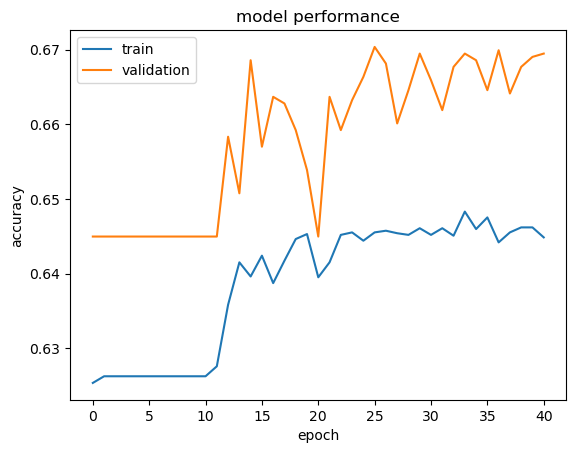

In [13]:
plot_hist(history)

In [14]:
# print confusion matrix and accuracy
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
cm = confusion_matrix(y_test, y_pred)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix: \n", cm)
print("\nclassification_report: \n", classification_report(y_test, y_pred))

71/71 [==============================] - 2s 11ms/step
Accuracy:  0.6694915254237288

Confusion Matrix: 
 [[1351   95]
 [ 646  150]]

classification_report: 
               precision    recall  f1-score   support

         0.0       0.68      0.93      0.78      1446
         1.0       0.61      0.19      0.29       796

    accuracy                           0.67      2242
   macro avg       0.64      0.56      0.54      2242
weighted avg       0.65      0.67      0.61      2242



In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 8, 128)            66560     
                                                                 
 dropout_4 (Dropout)         (None, 8, 128)            0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________


### Tuned Model


In [20]:
def model_builder(hp):
    model = Sequential()
    model.add(
        LSTM(
            units=hp.Int("units", min_value=32, max_value=256, step=32),
            return_sequences=True,
            input_shape=(X_train.shape[1], 1),
        )
    )
    model.add(Dropout(hp.Float("dropout", min_value=0.2, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int("units", min_value=32, max_value=256, step=32)))
    model.add(Dropout(hp.Float("dropout", min_value=0.2, max_value=0.5, step=0.1)))
    model.add(
        Dense(1, activation=hp.Choice(
            "dense_activation", ["tanh", "relu", "sigmoid"]))
    )
    model.compile(
        optimizer=hp.Choice("optimizer", ["adam", "rmsprop", "sgd"]),
        loss=hp.Choice("loss", ["binary_crossentropy"]),
        metrics=["accuracy", Precision(), Recall()],
    )
    return model

In [21]:
# RandomSearch to find the best hyperparameters
tuner = kt.RandomSearch(
    model_builder,
    objective="accuracy",
    max_trials=20,
    executions_per_trial=3,
    directory="tuned_models",
    project_name="lstm",
)

tuner.search(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)],
)

Trial 20 Complete [00h 00m 25s]
accuracy: 0.6262637575467428

Best accuracy So Far: 0.6263009309768677
Total elapsed time: 00h 13m 20s
INFO:tensorflow:Oracle triggered exit


In [22]:
# get params of best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)
best_hps.values

{'units': 64,
 'dropout': 0.2,
 'dense_activation': 'tanh',
 'optimizer': 'adam',
 'loss': 'binary_crossentropy'}

In [23]:
# get best model
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 8, 64)             16896     
                                                                 
 dropout_2 (Dropout)         (None, 8, 64)             0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [24]:
# build and fit best model
history = best_model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)],
)

Epoch 1/100
281/281 [==============================] - 8s 15ms/step - loss: 0.6809 - accuracy: 0.6257 - precision_1: 0.4074 - recall_1: 0.0033 - val_loss: 0.6509 - val_accuracy: 0.6450 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/100
281/281 [==============================] - 3s 11ms/step - loss: 0.6643 - accuracy: 0.6219 - precision_1: 0.3673 - recall_1: 0.0161 - val_loss: 0.6535 - val_accuracy: 0.6450 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/100
281/281 [==============================] - 3s 11ms/step - loss: 0.6638 - accuracy: 0.6269 - precision_1: 0.5652 - recall_1: 0.0078 - val_loss: 0.6508 - val_accuracy: 0.6450 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 4/100
281/281 [==============================] - 3s 11ms/step - loss: 0.6628 - accuracy: 0.6263 - precision_1: 1.0000 - recall_1: 2.9833e-04 - val_loss: 0.6528 - val_accuracy: 0.6450 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 5/100
281/281 [=======

In [25]:
# print confusion matrix and accuracy for best model
y_pred = best_model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
cm = confusion_matrix(y_test, y_pred)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix: \n", cm)
print("\nclassification_report: \n", classification_report(y_test, y_pred))

71/71 [==============================] - 1s 5ms/step
Accuracy:  0.6703835860838537

Confusion Matrix: 
 [[1363   83]
 [ 656  140]]

classification_report: 
               precision    recall  f1-score   support

         0.0       0.68      0.94      0.79      1446
         1.0       0.63      0.18      0.27       796

    accuracy                           0.67      2242
   macro avg       0.65      0.56      0.53      2242
weighted avg       0.66      0.67      0.60      2242



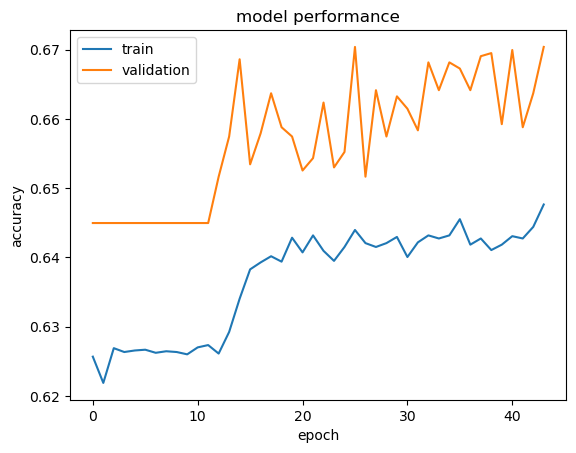

In [26]:
plot_hist(history)